<h1><center> <ins><b>Code Implementation of Modern Portfolio Theory (MPT)</b></ins> </center></h1>

<h2> <b><ins>Aims</ins></b></h2>

Having explained the fundamental ideas behind MPT in our previous notebook, I seek to provide some code to:

- Calculate expected returns via CAPM and covariances via Ledoit-Wolf Shrinkage Estimator
- Plot the covariance and correlation matrices via a heatmap
- Calculate the optimal weights for each asset for various strategies
- Visualise our Efficient Frontier with random portfolios, Capital Market Line and the points on our Frontier that are the above said optimal weights
- Find the optimal allocation of shares for each asset given a set of weights
- Plot the weights and allocation of each strategy via a grouped bar plot
- Produce a set of results that conclude what we have achieved

In [1]:
# Importing necessary libraries
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn import covariance
from sklearn.covariance import ledoit_wolf
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import re

In [2]:
# CvxPy gives us a warning when a solution may be inaccurate, we will ignore this message but this block can be deleted if one wants to keep the message
warnings.filterwarnings("ignore",
                        category=UserWarning,
                        message=re.escape("Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information."))

In [3]:
# Download historical data (OHLCV)
def price_data(stocks, start_date, end_date):
    df = yf.download(stocks,
                     interval = '1d', # Change interval if need be
                     start = start_date,
                     end = end_date,
                     #period = 'max', # Option to download prices as far back as possible
                     auto_adjust = True,
                     multi_level_index = False)
    df.index = pd.to_datetime(df.index)
    # We only require the closing prices
    df=df['Close']
    return df

# Calculate returns based on price data
def returns_data(df):
    # Calculate daily returns
    ret_df=df.pct_change().dropna()
    return ret_df

In [4]:
# Get list of DJIA stocks from wikipedia
temp = pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")[2]
temp['Symbol'] = temp['Symbol'].str.replace('.', '-')
stocks = temp['Symbol'].unique().tolist()

# Sort stocks alphabetically
stocks = sorted(stocks)

# Specify start and end dates
start_date = '2018-01-01'
end_date = '2025-03-01'

# Call price data and returns functions
df = price_data(stocks,start_date,end_date)
ret_df = returns_data(df)

[*********************100%***********************]  30 of 30 completed


In [5]:
# Function to calculate expected returns using CAPM
# Please refer to previous notebook for further information
def expected_returns(df, frequency, risk_free_rate):
    # Make a copy of returns dataframe to calculate the mean of all returns
    temp = df.copy()
    temp['mean_ret'] = df.mean(axis=1)
    
    # Calculate covariance and betas of assets
    cov = temp.cov()
    beta = cov["mean_ret"] / cov.loc["mean_ret", "mean_ret"]
    beta = beta.drop('mean_ret')
    mean_mkt_ret = (1 + temp['mean_ret']).prod() ** (frequency / len(temp['mean_ret'])) - 1
    
    # Calculate expected returns for each asset
    mu = risk_free_rate + beta * (mean_mkt_ret - risk_free_rate)
    return mu
mu = expected_returns(ret_df, 252, 0.041)

In [6]:
# Function to calculate covariances between each pair of assets using Ledoit-Wolf Shrinkage Estimator
# Please refer to previous notebook for further information
def covariance_matrix(df, frequency):
    # Use sklearn's ledoit_wolf function
    cov, shrinkage = ledoit_wolf(df)

    # Multiply by time period to annualise covariances
    cov = cov*frequency

    # Return results in a dataframe
    cov_df = pd.DataFrame(cov, columns=df.columns.to_numpy(), index=df.columns.to_numpy())
    return cov, cov_df
cov, cov_df = covariance_matrix(ret_df, frequency=252)

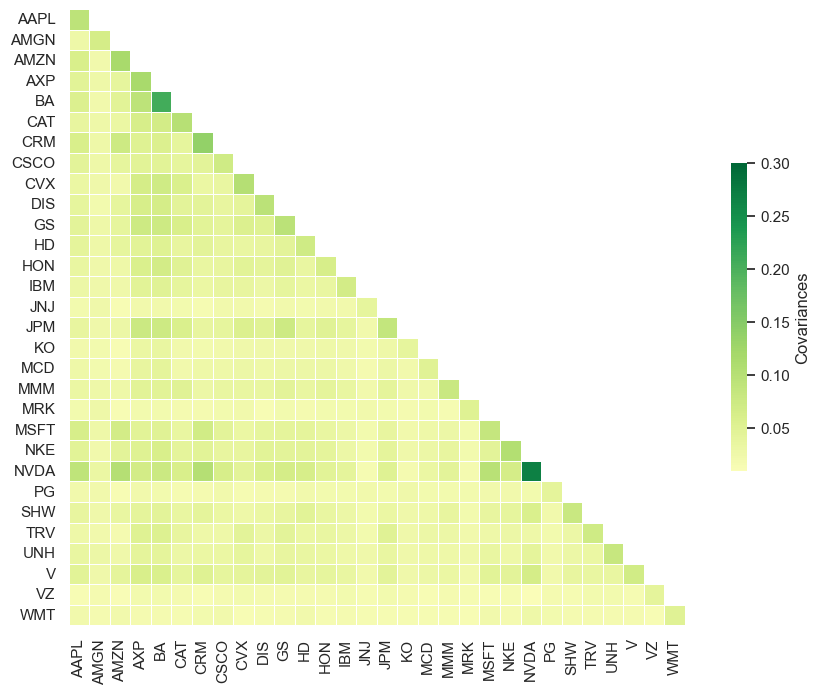

In [7]:
# Function to plot our covariances as a heatmap
def plot_covariance(cov):

    sns.set_theme(style="white")
    # Generate a mask for the upper triangle since our results are symmetrical so we only need one diagonal of results
    mask = np.zeros_like(cov)
    mask[np.triu_indices_from(mask, k=1)] = True
    
    # Initialise matplotlib figure
    f, ax = plt.subplots(figsize=(12, 8))
    
    # Draw the heatmap
    sns.heatmap(cov, ax=ax, mask=mask, cmap='RdYlGn', vmax=.3, center=0,
                annot=False, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    colorbar = ax.collections[0].colorbar
    colorbar.set_label("Covariances")

    plt.show()
    return
plot_covariance(cov_df)

<h2> <ins>Calculating correlations based on our covariances</ins> </h2>

Recall the definition of correlation between a variable $X$ and $Y$ is,
$$\text{Corr}\left(X,Y\right) = \frac{\text{Cov}\left(X,Y\right)}{\sigma_{X}\sigma_{Y}}$$
$$\implies \text{Cov}\left(X,Y\right) = \sigma_{X}\,\text{Corr}\left(X,Y\right)\,\sigma_{Y}$$
Now let
- $\mathbf{C} \in \mathbb{R}^{n \times n}$ represent a covariance matrix between n variables
- $\mathbf{R} \in \mathbb{R}^{n \times n}$ represent a correlation matrix between n variables
- $\mathbf{V} \in \mathbb{R}^{n \times n}$ represent a diagonal standard deviation matrix where $\mathbf{V} = \text{diag}\left(\sigma_{1},\,\sigma_{2},\,...\,,\,\sigma_{n}\right)$.

Then we can say
$$\mathbf{C} = \mathbf{R}\mathbf{V}\mathbf{R} \implies \mathbf{V} = \mathbf{R}^{-1}\mathbf{C}\mathbf{R}^{-1}$$

However since $\mathbf{V}$ is a diagonal matrix, we can use the neat property about the inverses of such matrices. For a diagonal matrix $\mathbf{D} = \left(d_{ii}\right)_{i=1}^{n}$ , its inverse $\mathbf{D}^{-1} = \left(\frac{1}{d_{ii}}\right)_{i=1}^{n}$.

We will use this to easily calculate the correlation matrix for our portfolio.

In [8]:
# Function to calculate the correlations between any pair of assets based on our earlier calculated covariances
def correlation_matrix(cov):
    V = np.diag(1 / np.sqrt(np.diag(cov)))
    corr = V @ cov @ V
    corr_df = pd.DataFrame(corr, index=df.columns.to_numpy(), columns=df.columns.to_numpy())
    return corr_df

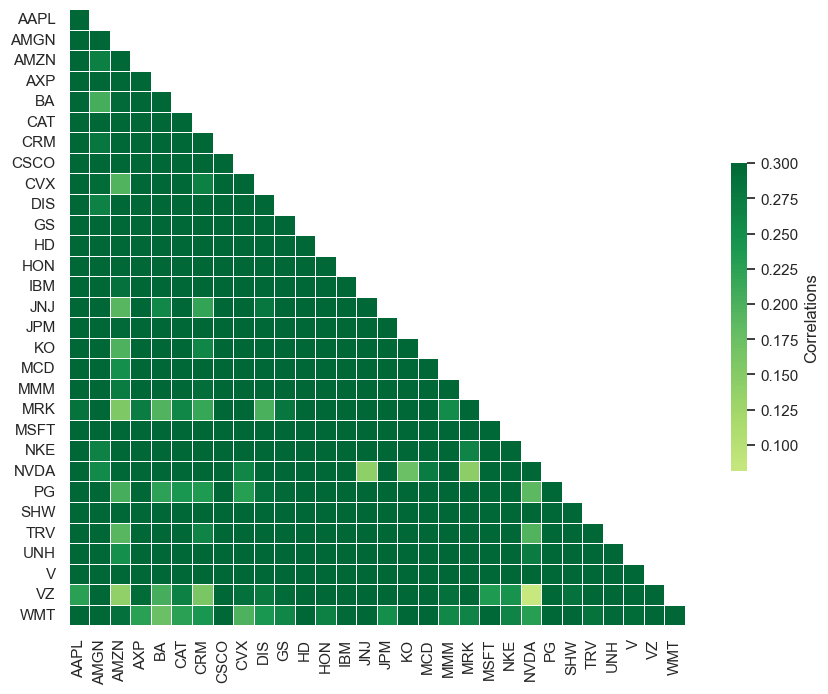

In [9]:
# Function to plot our correlations as a heatmap
def plot_correlation(cov):
    # Calculate correlations
    corr_df = correlation_matrix(cov)

    sns.set_theme(style="white")
    # Generate a mask for the upper triangle since our results are symmetrical so we only need one diagonal of results
    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask, k=1)] = True
    
    # Initialise matplotlib figure
    f, ax = plt.subplots(figsize=(12, 8))
    
    # Draw the heatmap
    sns.heatmap(corr_df, ax=ax, mask=mask, cmap='RdYlGn', vmax=.3, center=0,
                annot=False, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    colorbar = ax.collections[0].colorbar
    colorbar.set_label("Correlations")

    plt.show()
    return
plot_correlation(cov)

In [10]:
# Small function to make our weights more readable
# We simply use a cutoff approach to set negligible weights to 0 and round all weights to 7dp
def final_weights(weights, cutoff=1e-5, rounding=7):
    weights[np.abs(weights) < cutoff] = 0
    final_weights = np.round(weights, rounding)
    return final_weights

In [11]:
# Function to find a set of weights that maximise our expected returns
def maximise_return(ret, cov, weight_bounds, results=False):
    
    # Create cvxpy variable to minimize
    w = cp.Variable(len(ret))
    
    # Construct the objective function and constraints
    obj = cp.Minimize(-w.T @ ret)
    const = [cp.sum(w) == 1,
             w >= weight_bounds[0],
             w <= weight_bounds[1]]
    
    # Solve problem
    prob = cp.Problem(obj, const)
    opt_v = prob.solve()

    # Check to see if our optimisation failed
    if w.value is None:
        raise RuntimeError("Optimization failed: no solution found. Please ensure appropriate expected returns and weight bounds were provided.")
        
    # Get our optimal weights and corresponding portfolio return and risk
    w = w.value.round(10) + 0.0
    returns = float(w.T @ ret.to_numpy())
    risk = float(np.sqrt(w.T @ cov @ w))
    # Put weights in a pandas series
    weights = pd.Series(final_weights(w), index=ret.index.to_list())

    # Print results if needed otherwise just return results
    if results:
        print(f'For our return maximising optimisation, we achieve results of:\n')
        print('Return (%):', np.round(returns*100, 5))
        print('Risk (%):', np.round(risk*100, 5))
        print('Weights:\n')
        print(weights.to_string(dtype=False))
        return returns, risk, weights
    else:
        return returns, risk, weights

In [12]:
# Call our returns maximising function
ret_max, risk_max, weights_max = maximise_return(mu, cov, weight_bounds=[-1,1], results=True)

For our return maximising optimisation, we achieve results of:

Return (%): 93.52976
Risk (%): 238.25827
Weights:

AAPL    1.0
AMGN   -1.0
AMZN    1.0
AXP     1.0
BA      1.0
CAT     1.0
CRM     1.0
CSCO   -1.0
CVX     1.0
DIS     1.0
GS      1.0
HD      1.0
HON     0.0
IBM    -1.0
JNJ    -1.0
JPM     1.0
KO     -1.0
MCD    -1.0
MMM    -1.0
MRK    -1.0
MSFT    1.0
NKE     1.0
NVDA    1.0
PG     -1.0
SHW    -1.0
TRV    -1.0
UNH    -1.0
V       1.0
VZ     -1.0
WMT    -1.0


In [13]:
# Function to find a set of weights that minimise our risk
# Please refer to previous notebook on derivations and explanations behind this optimisation
def minimise_risk(ret, cov, target_return, weight_bounds, results=False):
    # Ensure that the target return provided is actually attainable by ensuring that is below the maximum possible return
    max_ret = maximise_return(ret, cov, weight_bounds)[0]
    if target_return > max_ret:
        print(f'The target return of {target_return*100}% provided exceeds the maximum achievable return {max_ret*100:.3f}%.')
        print(f'We will proceed with a target return of {np.floor(max_ret*1e3)/10}%.\n')
        target_return = np.floor(max_ret*1e3)/1e3
    
    # Create cvxpy variable to minimize
    w = cp.Variable(len(ret))
    
    # Construct the objective function and constraints
    obj = cp.Minimize(w.T @ cov @ w)
    const = [cp.sum(w) == 1,
         (w.T @ ret) - target_return >= 0,
         w >= weight_bounds[0],
         w <= weight_bounds[1]]
    
    # Solve problem
    prob = cp.Problem(obj, const)
    try:
        opt_v = prob.solve(solver=cp.OSQP)
    except cp.SolverError:
        try:
            opt_v = prob.solve(solver=cp.ECOS)
        except cp.SolverError:
            opt_v = prob.solve(solver=cp.SCS)

    # Check to see if our optimisation failed
    if w.value is None:
        raise RuntimeError("Optimization failed: no solution found. Please ensure appropriate expected returns, covariance matrix and weight bounds were provided.")
    
    # Get our optimal weights and corresponding portfolio return and risk
    w = w.value.round(10) + 0.0
    returns = float(w.T @ ret)
    risk = float(np.sqrt(opt_v))
    weights = pd.Series(final_weights(w), index=ret.index.to_list())

    # Print results if needed otherwise just return results
    if results:
        print(f'For our efficient risk minimising optimisation with a target return of {np.floor(target_return*1e3)/10}%, we achieve results of:\n')
        print('Return (%):', np.round(returns*100, 5))
        print('Risk (%):', np.round(risk*100, 5))
        print('Weights:\n')
        print(weights.to_string(dtype=False))
        return returns, risk, weights
    else:
        return returns, risk, weights

In [14]:
ret_mr, risk_mr, w_mr = minimise_risk(mu, cov, target_return=0, weight_bounds=[-1,1], results=True)

For our efficient risk minimising optimisation with a target return of 0.0%, we achieve results of:

Return (%): 10.95748
Risk (%): 14.25973
Weights:

AAPL   -0.010293
AMGN    0.013092
AMZN    0.096020
AXP    -0.075516
BA     -0.031413
CAT     0.029083
CRM     0.017414
CSCO   -0.037637
CVX     0.019601
DIS     0.041346
GS     -0.000165
HD     -0.045596
HON     0.047413
IBM     0.022521
JNJ     0.145805
JPM    -0.000556
KO      0.117688
MCD     0.146582
MMM     0.021342
MRK     0.102202
MSFT   -0.052556
NKE    -0.009409
NVDA    0.000611
PG      0.063611
SHW     0.009906
TRV     0.016175
UNH    -0.012083
V       0.002384
VZ      0.196215
WMT     0.166213


In [15]:
# Function to find a set of weights that maximise our sharpe ratio
# Please refer to previous notebook on derivations and explanations behind this optimisation
def maximise_sharpe_ratio(ret, cov, risk_free_rate, weight_bounds, results=False):
    
    # Create cvxpy variables
    w = cp.Variable(len(ret))
    k = cp.Variable()
    
    # Construct the objective function and constraints
    obj = cp.Minimize(w.T @ cov @ w)
    const = [w.T @ (ret - risk_free_rate) == 1,
             cp.sum(w) == k,
             w >= weight_bounds[0],
             w <= weight_bounds[1],
             k >= 0]
    
    # Solve problem
    prob = cp.Problem(obj, const)
    prob.solve()

    # Check to see if our optimisation failed
    if w.value is None:
        raise RuntimeError("Optimization failed: no solution found. Please ensure appropriate expected returns, covariance matrix and weight bounds were provided.")
        
    # Get our optimal weights and corresponding portfolio return and risk
    w = (w.value/k.value).round(10) + 0.0
    returns = float(w.T @ ret)
    risk = float(np.sqrt(w.T @ cov @ w))
    weights = pd.Series(final_weights(w), index=ret.index.to_list())

    # Print results if needed otherwise just return results
    if results:
        print('For our sharpe ratio maximising optimisation, we achieve results of:\n')
        print('Return (%):', np.round(returns*100, 5))
        print('Risk (%):', np.round(risk*100, 5))
        print('Sharpe Ratio:', np.round(((returns - risk_free_rate)/ risk), 5))
        print('Weights:\n')
        print(weights.to_string(dtype=False))
        return returns, risk, weights
    else:
        return returns, risk, weights

In [16]:
ret_msr, risk_msr, w_msr = maximise_sharpe_ratio(mu, cov, risk_free_rate=0.041, weight_bounds=[-1,1], results=True)

For our sharpe ratio maximising optimisation, we achieve results of:

Return (%): 15.98742
Risk (%): 18.7747
Sharpe Ratio: 0.63316
Weights:

AAPL    0.033447
AMGN    0.033386
AMZN    0.033170
AXP     0.033618
BA      0.033502
CAT     0.033344
CRM     0.033375
CSCO    0.033519
CVX     0.033369
DIS     0.033312
GS      0.033421
HD      0.033539
HON     0.033297
IBM     0.033362
JNJ     0.033040
JPM     0.033422
KO      0.033113
MCD     0.033037
MMM     0.033365
MRK     0.033153
MSFT    0.033558
NKE     0.033445
NVDA    0.033419
PG      0.033254
SHW     0.033395
TRV     0.033378
UNH     0.033452
V       0.033414
VZ      0.032908
WMT     0.032986


In [17]:
# Function to plot our portfolio efficient frontier with random portfolios, where our minimum risk and maximum sharpe ratio portfolios are and Capital Market Line
# For certain weight bounds, mostly when we include negative short weights, our efficient frontier is extremely large, so we will produce another plot that is a zoomed in version
def plot_ef(ret, cov, risk_free_rate, weight_bounds, ef_points=500, n=50000):
    
    # Initialise a Plotly figure with subplots
    fig = make_subplots(rows=2, cols=1, subplot_titles=["Full Efficient Frontier", "Zoomed Efficient Frontier"], vertical_spacing=0.1)
    """
    Plot random portfolios
    """
    # Create random portfolios to calculate expected returns, risks and sharpe ratios for our plot
    random_w = []
    while len(random_w) < n:
        # Create a mask to ensure we get a set of weights where some assets have a weight of 0
        mask = np.random.binomial(1, 0.8, size=len(ret))
        w = np.random.uniform(weight_bounds[0], weight_bounds[1], size=len(ret)) * mask
        
        # Ensure weights do not sum to 0, so that we can normalise our weights to make them sum to 1
        w_sum = np.sum(w)
        if w_sum == 0:
            continue
        w = w / w_sum
        
        # Check all weights are still within bounds and append to final list of all weights
        if np.all(w >= weight_bounds[0]) and np.all(w <= weight_bounds[1]):
            random_w.append(w)

    # Calculate each portfolio's return, risk and sharpe ratio
    # Note how instead of using a massive for loop for each set of weights, we combine them all into one big array and only require one calculation to find each set of results
    random_w = np.array(random_w)
    random_rets = random_w @ ret
    random_risks = np.sqrt(np.einsum('ij,jk,ik->i', random_w, cov, random_w))
    random_sharpes = (random_rets-risk_free_rate) / random_risks

    # Plot our random portfolios (risk against return) and including a colour scale dependent on sharpe ratio
    Random_Portfolios = go.Scatter(x=random_risks*100,y=random_rets*100,
                                    mode="markers",
                                    name="Random Portfolios",
                                    marker=dict(size=6, opacity=0.5,
                                                color=random_sharpes,colorscale='Viridis',colorbar=dict(title='Sharpe Ratio', len=0.45, y=1.0, yanchor='top'),
                                                showscale=True),
                                    showlegend=True)
    Random_Portfolios2 = go.Scatter(x=random_risks*100,y=random_rets*100,
                                    mode="markers",
                                    name="Random Portfolios",
                                    marker=dict(size=6, opacity=0.5,
                                                color=random_sharpes,colorscale='Viridis',colorbar=dict(title='Sharpe Ratio', len=0.45, y=0.0, yanchor='bottom'),
                                                showscale=True),
                                    showlegend=False)
    fig.add_trace(Random_Portfolios, row=1, col=1)
    fig.add_trace(Random_Portfolios2, row=2, col=1)

    # Calculate the minimum and maximum risks and returns possible with the given set of assets
    min_ret, min_risk = minimise_risk(ret, cov, target_return=0, weight_bounds=weight_bounds)[:2]
    max_ret, max_risk = maximise_return(ret, cov, weight_bounds=weight_bounds)[:2]
    """
    Plot Efficient Frontier
    """
    # Create a set of returns that are attainable 
    rets = np.linspace(min_ret, max_ret, ef_points)

    # For each return, we find the corresponding minimum risk 
    ret_ef=[]
    risk_ef=[]
    for i in rets:
        i_ret,i_risk = minimise_risk(ret, cov, target_return=i, weight_bounds=weight_bounds)[:2]
        ret_ef.append(i_ret*100)
        risk_ef.append(i_risk*100)

    # Plot our calculated efficient frontier points
    Efficient_Frontier = go.Scatter(x=risk_ef,y=ret_ef,
                                    mode="lines",
                                    name="Efficient frontier",
                                    line=dict(width=3, color="lightskyblue"),
                                    showlegend=True)
    Efficient_Frontier2 = go.Scatter(x=risk_ef,y=ret_ef,
                                    mode="lines",
                                    name="Efficient frontier",
                                    line=dict(width=3, color="lightskyblue"),
                                    showlegend=False)
    fig.add_trace(Efficient_Frontier, row=1, col=1)
    fig.add_trace(Efficient_Frontier2, row=2, col=1)
    """
    Plot individual assets' returns and risks using our expected returns and covariance matrix
    """
    Assets = go.Scatter(x=np.sqrt(np.diag(cov))*100,y=mu*100,
                        mode="markers",
                        name="Assets",
                        marker=dict(size=8, symbol="star", color="black"),
                        showlegend=True)
    Assets2 = go.Scatter(x=np.sqrt(np.diag(cov))*100,y=mu*100,
                         mode="markers",
                         name="Assets",
                         marker=dict(size=8, symbol="star", color="black"),
                         showlegend=False)
    fig.add_trace(Assets, row=1, col=1)
    fig.add_trace(Assets2, row=2, col=1)
    """
    Plot the point on our efficient frontier where the portfolio with the minimal risk is
    """
    Min_Risk = go.Scatter(x=[min_risk*100],y=[min_ret*100],
                          mode="markers",
                          name="Minimum Volatility",
                          marker=dict(size=10, symbol="x", color="green"),
                          showlegend=True)
    Min_Risk2 = go.Scatter(x=[min_risk*100],y=[min_ret*100],
                          mode="markers",
                          name="Minimum Volatility",
                          marker=dict(size=10, symbol="x", color="green"),
                          showlegend=False)
    fig.add_trace(Min_Risk, row=1, col=1)
    fig.add_trace(Min_Risk2, row=2, col=1)
    """
    Plot the point on our efficient frontier where the portfolio with the maximal sharpe ratio is
    """
    ret_msr, risk_msr = maximise_sharpe_ratio(mu, cov, risk_free_rate=0.041, weight_bounds=weight_bounds)[:2]
    Max_Sharpe_Ratio = go.Scatter(x=[risk_msr*100],y=[ret_msr*100],
                                  mode="markers",
                                  name="Maximum Sharpe Ratio",
                                  marker=dict(size=10, symbol="x", color="red"),
                                  showlegend=True)
    Max_Sharpe_Ratio2 = go.Scatter(x=[risk_msr*100],y=[ret_msr*100],
                                  mode="markers",
                                  name="Maximum Sharpe Ratio",
                                  marker=dict(size=10, symbol="x", color="red"),
                                  showlegend=False)
    fig.add_trace(Max_Sharpe_Ratio, row=1, col=1)
    fig.add_trace(Max_Sharpe_Ratio2, row=2, col=1)
    """
    Plot our Capital Market Line (CML)
    Refer to previous notebook where we proved that this line is:
    - Tangent to the Efficient Frontier
    - Intersects at the maximum sharpe ratio portfolio
    - Has a y-intercept at the risk free rate
    """
    # Our 2 points that will form the line
    x1, y1 = 0, risk_free_rate
    x2, y2 = risk_msr, ret_msr
    # Limit the range of the CML
    y_vals = np.array([risk_free_rate, max_ret])
    # Calculate slope (intercept is just simply the risk free rate) 
    m = (y2 - y1) / (x2 - x1)
    # Get corresponding x-values for the 2 y values
    x_vals = (y_vals - y1) / m
    # Plot CML
    CML = go.Scatter(x=x_vals*100, y=y_vals*100,
                     mode='lines',
                     name='Capital Market Line',
                     line=dict(color='brown', width=4, dash='dot'),
                     showlegend=True)
    CML2 = go.Scatter(x=x_vals*100, y=y_vals*100,
                     mode='lines',
                     name='Capital Market Line',
                     line=dict(color='brown', width=4, dash='dot'),
                     showlegend=False)
    fig.add_trace(CML, row=1, col=1)
    fig.add_trace(CML2, row=2, col=1)
    """
    Plot horizontal line representing risk free rate
    """
    rf_x = np.array([0,max_risk])
    rf_y = np.array([risk_free_rate,risk_free_rate])
    RF = go.Scatter(x=rf_x*100, y=rf_y*100,
                    mode='lines',
                    name='Risk Free Rate',
                    line=dict(color='orange', width=4, dash='dot'),
                    showlegend=True)
    RF2 = go.Scatter(x=rf_x*100, y=rf_y*100,
                    mode='lines',
                    name='Risk Free Rate',
                    line=dict(color='orange', width=4, dash='dot'),
                    showlegend=False)
    fig.add_trace(RF, row=1, col=1)
    fig.add_trace(RF2, row=2, col=1)
    """
    Update plot size, legend, titles and axes
    """
    fig.update_layout(width=1400,height=1800,
                     legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.6)', bordercolor='black', borderwidth=1),
                     margin=dict(l=100,r=100),
                     title=dict(text='Efficient Frontier Plots', font=dict(size=40)))
    for annotation in fig['layout']['annotations']:
        annotation['font'] = dict(size=30)
    fig.update_xaxes(title='Annualised Volatility (%)', title_font=dict(size=30), row=1, col=1)
    fig.update_yaxes(title='Annualised Return (%)', title_font=dict(size=30), row=1, col=1)
    fig.update_xaxes(title='Annualised Volatility (%)', range=[0, random_risks.max()*100 +5], title_font=dict(size=30), row=2, col=1)
    fig.update_yaxes(title='Annualised Return (%)', range=[random_rets.min()*100 +5, random_rets.max()*100 +5], title_font=dict(size=30), row=2, col=1)
    
    # Show plot
    fig.show()
    return

In [18]:
plot_ef(mu, cov, risk_free_rate=0.041, weight_bounds=[-1,1])

In [19]:
# Function to find the optimal allocation of our assets given a set of weights
# Please refer to the previous notebook for the explanation of the ideas behind this, especially when dealing with short positions
def allocation(prices, weights, total_investment, short_ratio=0.5, reinvest=False, remove_zero_investments=True, results=False):
    
    # Handle case where weights include short positions
    if (weights < 0).any():
        longs = weights[weights >= 0]
        shorts = weights[weights < 0]

        # Normalize both the long and short weights
        longs = longs / longs.sum()
        shorts = shorts / shorts.sum()

        # Calculate how much we have to allocate for both the long and short positions
        short_val = total_investment * short_ratio
        long_val = total_investment + short_val if reinvest else total_investment

        # Recursively apply function for long and short positions separately
        long_alloc, long_leftover = allocation(prices[longs.index], longs, long_val, reinvest=False, remove_zero_investments=remove_zero_investments, results=False)
        short_alloc, short_leftover = allocation(prices[shorts.index], shorts, short_val, reinvest=False, remove_zero_investments=remove_zero_investments, results=False)

        # Negate shorts to turn them into longs and get combined results
        short_alloc = -short_alloc
        combined_alloc = pd.concat([long_alloc, short_alloc]).groupby(level=0).sum()
        # if remove_zero_investments:
        #     combined_alloc = combined_alloc[combined_alloc != 0]
        combined_leftover = long_leftover + short_leftover

        # Print results if results=True, else return allocation and leftover amount
        if results:
            print(f"Remaining cash: {combined_leftover:.2f}\n")
            print(f"Allocation:\n{combined_alloc.to_string(dtype=False)}")

        # Return allocations and leftover amount
        return combined_alloc, combined_leftover

    # Long only positions
    # Define variables
    tickers = weights.index
    p = prices.to_numpy()
    w = weights.to_numpy()
    n = len(w)

    # Create cvxpy variables and ensure each allocation is an integer
    x = cp.Variable(n, integer=True)
    u = cp.Variable(n)

    # Calculate the amount of money spent from buying shares and how much we have leftover
    spent = p @ x
    leftover = total_investment - spent

    # Calculate the absolute deviation from target allocation
    target = w * total_investment
    error = target - cp.multiply(x, prices)

    # Construct the objective function and constraints
    objective = cp.Minimize(cp.sum(u) + leftover)
    constraints = [error <= u,
                   error >= -u,
                   x >= 0,
                   leftover >= 0]

    # Solve problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver="ECOS_BB")

    # Find final allocation by removing assets with no investment into them if remove_zero_investments is trueinto them and set as a pandas series
    allocation_final = pd.Series(np.rint(x.value).astype(int), index=tickers)
    if remove_zero_investments:
        allocation_final = allocation_final[allocation_final != 0]

    # Print results if results=True, else return allocation and leftover amount
    if results and (weights > 0).all():
        print(f"Leftover cash: {leftover.value:.2f}\n")
        print(f"Allocation:\n{allocation_final.to_string(dtype=False)}")

    return allocation_final, leftover.value

In [20]:
alloc, cash = allocation(df.iloc[-1], w_msr, total_investment=10_000, reinvest=False, remove_zero_investments=False, results=True)

Leftover cash: 41.06

Allocation:
AAPL    1
AMGN    1
AMZN    1
AXP     1
BA      2
CAT     1
CRM     1
CSCO    5
CVX     2
DIS     3
GS      1
HD      1
HON     1
IBM     1
JNJ     2
JPM     1
KO      5
MCD     1
MMM     2
MRK     4
MSFT    1
NKE     4
NVDA    3
PG      2
SHW     1
TRV     1
UNH     1
V       1
VZ      8
WMT     3


In [21]:
def plot_weights(ret, cov, weight_bounds, risk_free_rate=0.041):
    # Get an array of tickers in our portfolio
    tickers = ret.index.to_numpy()

    # Calculate the optimal weights for each strategy
    _, _, w_max = maximise_return(ret, cov, weight_bounds=weight_bounds)
    _, _, w_mr = minimise_risk(ret, cov, target_return=0, weight_bounds=weight_bounds)
    _, _, w_msr = maximise_sharpe_ratio(ret, cov, risk_free_rate, weight_bounds=weight_bounds)

    # Initialise plotly figure
    fig = go.Figure()

    # Plot bar charts, for our max return strategy we will make it invisible since the weights are extreme and not realisitc
    fig.add_trace(go.Bar(name='Max Return', x=tickers, y=w_max, visible='legendonly'))
    fig.add_trace(go.Bar(name='Min Risk', x=tickers, y=w_mr))
    fig.add_trace(go.Bar(name='Max Sharpe Ratio', x=tickers, y=w_msr))

    # Group bars and edit axes and title
    fig.update_layout(width=1400,height=900,
                      barmode='group',
                      title=dict(text='Asset Weights for Each Strategy', font=dict(size=40)))
    fig.update_xaxes(title='Assets', title_font=dict(size=30), tickangle=-45)
    fig.update_yaxes(title='Weight', title_font=dict(size=30))
    
    fig.show()
    return
plot_weights(mu, cov, weight_bounds=[-1,1], risk_free_rate=0.041)

In [22]:
def plot_allocations(ret, cov, weight_bounds, risk_free_rate=0.041, total_investment=10_000):
    # Get an array of tickers in our portfolio
    tickers = ret.index.to_numpy()

    # Calculate the optimal weights for each strategy
    _, _, w_max = maximise_return(ret, cov, weight_bounds=weight_bounds)
    _, _, w_mr = minimise_risk(ret, cov, target_return=0, weight_bounds=weight_bounds)
    _, _, w_msr = maximise_sharpe_ratio(ret, cov, risk_free_rate, weight_bounds=weight_bounds)

    alloc_max, _ = allocation(df.iloc[-1], w_max, total_investment=total_investment, remove_zero_investments=False)
    alloc_mr, _ = allocation(df.iloc[-1], w_mr, total_investment=total_investment, remove_zero_investments=False)
    alloc_msr, _ = allocation(df.iloc[-1], w_msr, total_investment=total_investment, remove_zero_investments=False)

    # Initialise plotly figure
    fig = go.Figure()

    # Plot bar charts
    fig.add_trace(go.Bar(name='Max Return', x=tickers, y=alloc_max))
    fig.add_trace(go.Bar(name='Min Risk', x=tickers, y=alloc_mr))
    fig.add_trace(go.Bar(name='Max Sharpe Ratio', x=tickers, y=alloc_msr))

    # Group bars and edit axes and title
    fig.update_layout(width=1400,height=900,
                      barmode='group',
                      title=dict(text='Number of Allocated Shares of each Asset for each Strategy', font=dict(size=40)))
    fig.update_xaxes(title='Assets', title_font=dict(size=30), tickangle=-45)
    fig.update_yaxes(title='Number of Shares', title_font=dict(size=30))
    
    fig.show()
    return
plot_allocations(mu, cov, weight_bounds=[-1,1], risk_free_rate=0.041, total_investment=10_000)

In [23]:
def full_results(df, ret, cov, weight_bounds, risk_free_rate=0.041, total_investment=10_000, results=False):
    # Calculate returns, volatilities, weights and sharpe ratios of all strategies
    ret_max, risk_max, w_max = maximise_return(ret, cov, weight_bounds=weight_bounds)
    sr_max = (ret_max - risk_free_rate)/risk_max
    ret_mr, risk_mr, w_mr = minimise_risk(ret, cov, target_return=0, weight_bounds=weight_bounds)
    sr_mr = (ret_mr - risk_free_rate)/risk_mr
    ret_msr, risk_msr, w_msr = maximise_sharpe_ratio(ret, cov, risk_free_rate, weight_bounds=weight_bounds)
    sr_msr = (ret_msr - risk_free_rate)/risk_msr

    # Create our metrics result dataframe
    metrics = pd.DataFrame({'Strategy': ['Max Return', 'Min Risk', 'Max Sharpe Ratio'],
                            'Return (%)': [ret_max*100, ret_mr*100, ret_msr*100],
                            'Volatility (%)': [risk_max*100, risk_mr*100, risk_msr*100],
                            'Sharpe Ratio': [sr_max, sr_mr, sr_msr]})
    metrics.set_index("Strategy", inplace=True)

    # Create multi index of strategies and tickers
    tickers = list(df.columns)*3
    length = len(df.columns)
    strats = ['Max Return']*length + ['Min Volatility']*length + ['Max Sharpe Ratio']*length
    arrays = [strats,tickers]

    # Calculate allocations and leftover amount of all strategies
    alloc_max, leftover_max = allocation(df.iloc[-1], w_max, total_investment=total_investment, remove_zero_investments=False)
    alloc_mr, leftover_mr = allocation(df.iloc[-1], w_mr, total_investment=total_investment, remove_zero_investments=False)
    alloc_msr, leftover_msr = allocation(df.iloc[-1], w_msr, total_investment=total_investment, remove_zero_investments=False)

    # Create our distribution dataframe
    distribution = pd.DataFrame({'Weights': np.concatenate([w_max, w_mr, w_msr]), 'Allocations': np.concatenate([alloc_max, alloc_mr, alloc_msr])}, index=arrays)
    distribution = distribution.rename_axis(index=['Strategy', 'Ticker'])

    # Create our leftovers dataframe
    leftovers = pd.DataFrame({'Strategy': ['Max Return', 'Min Risk', 'Max Sharpe Ratio'],
                              'Leftover Amount': [leftover_max, leftover_mr, leftover_msr]})
    leftovers.set_index("Strategy", inplace=True)

    # Display dataframes if results=True, else simply return dataframes
    if results:
        display(metrics)
        display(distribution)
        display(leftovers)
    
    return metrics, distribution, leftovers
          
metrics, distribution, leftovers = full_results(df, mu, cov, weight_bounds=[-1,1], risk_free_rate = 0.041, results=True)

,Return (%),Volatility (%),Sharpe Ratio
Strategy,,,
Max Return,93.529758,238.258272,0.375348
Min Risk,10.957477,14.259729,0.480898
Max Sharpe Ratio,15.987423,18.774697,0.633162


Weights  Allocations
Strategy         Ticker                       
Max Return       AAPL    1.000000            3
                 AMGN   -1.000000           -1
                 AMZN    1.000000            3
                 AXP     1.000000            2
                 BA      1.000000            4
...                           ...          ...
Max Sharpe Ratio TRV     0.033378            1
                 UNH     0.033452            1
                 V       0.033414            1
                 VZ      0.032908            8
                 WMT     0.032986            3

[90 rows x 2 columns]

,Leftover Amount
Strategy,
Max Return,66.522164
Min Risk,74.395429
Max Sharpe Ratio,41.060775
